# Sistemas de Recomendación - Netflix Prize Challenge

Vamos a implementar un sistema de recomendación a través de un filtro colaborativo. Como son varios los pasos que debemos dar, está dividido en dos notebooks. Uno orientado al preprocesamiento y exploración de datos, y otro a la implementación de las técnicas que vimos.

Algunas referencias útiles, además de las mencionadas en la presentación:
* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
* https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101

El dataset puede ser descargado [acá](https://www.kaggle.com/netflix-inc/netflix-prize-data)

Importante leer el archivo `README.md` para la descripción de los archivos.

## Teoría

* __Matriz de Utilidad:__ contiene Usuarios e Items.
* __Matriz Dispersa:__ es aquella en la que hay muchas celdas en blanco, porque el usuario no compró o no evaluó, etc.  
* La idea es poder recomendar a cada usuario la película/canción/producto para él.
* La idea es poblar la matriz de Utilidad, es decir, llenar los espacios vacíos.

### Sistemas de Recomendación

* __Recomendación Basada en Contenido:__ buscar características/atributos/metadatos/info del producto y encontrar similares. Buscamos a qué se parece pero en el texto, en la base de datos.
    * Ventajas: sólo se necesita saber del producto que yo consumo y buscar otro que se parezca en base a su contenido, para luego recomendármelo // No es costoso.
    * Desventajas: no siempre es fácil encontrar los productos que buscamos // Suele recomendar items que no son novedosos para el usuario.

* __Recomendación Colaborativa:__ se buscan Usuarios similares a mi, y de acuerdo a ello, se usan los productos que ellos consumen para recomendarmelos a mí (que yo no he usado, consumido, escuchado, etc.). Se utiliza lo que se sabe de mí y en función de ello se buscan usuarios que se parecen a mí.
    * Ventajas: no necesito tener info acerca de los productos.
    * Desventajas: necesitamos tener la matríz de utilidad (que es muy dispersa) y llenarla es costosa en tiempo y dinero.

* __Modelo de Clasificación:__ basado en contenidos. Elegimos un modelo matemático SVM, Regresión, K-vecinos, y hacemos predicciones.

### Modelos a Utilizar para poblar la matriz de Utilidad

* P/ BIG DATA, se utilizan técnicas como ALS model,  SVD (el que vimos), SVD ++, Descenso Gradiente (a la profe no le gusta porque no es óptimo ni rápido).
* Ella primero llena la matriz de utilidad con ALS y después aplica Descenso Gradiente.

* Importar __Surprise!:__ SVD, SVD++, NMF, MDS.
* Netflix utiliza una variante de Surprise.

* Para el proyecto 3, usar Surprise Lib, no usar el notebook de coseno pq es muy largo.

## Grandes Volúmenes de Datos

Uno de los desafíos que plantea este dataset es que es bastante "grande". Esto quiere decir que, si lo cargamos completo, ocupa bastante lugar en nuestra memoria RAM. Además, cada tarea puede llevar mucho tiempo. Entonces, es necesario plantear una estrategia para abordarlo. Existen varias posibilidades, mencionamos algunas:
1. Recortar una parte del dataset con la que sí podamos trabajar. Esta parte tiene que ser lo suficientemente representativa del set original. Para estar seguros/as de ello es fundamental hacer una buena exploración de datos. Con ese recorte, entrenamos y evaluamos nuestro modelo, y optimizamos parámetros (CV). Una vez que ya estamos seguro de que nuestro flujo de trabajo es apropiado, podemos probar agrandar la porción de datos con la que entrenamos o utilizar otro recorte del dataset. Eventualmente, podemos llegar a usar todo el dataset para entrenar y evaluar si nuestra computadora lo permite. **NOTA**: el recorte se hace para que se pueda cargar en memoria los datos pero también para que cada iteración lleve un tiempo razonable.
2. **Aprendizaje incremental**: algunos modelos pueden ser entrenados mostrándoles el dataset de a pedazos. Es decir, no necesitan ver todo el dataset a la vez. Un ejemplo son las redes neuronales, que "ven" muchas pasadas del dataset en *epochs* y *minibatches* __Nota (1)__. Algunos modelos en Scikit-learn tienen la función `partial_fit` que permite hacer eso. Pueden leer un poco al respecto [acá](https://scikit-learn.org/stable/modules/computing.html). Pandas también tiene funciones que permiten cargar el dataset de a trozos.
3. Utilizar servicios en la nube. Esta opción no es excluyente con las anteriores. Antes de utilizar algún entorno en la nube, está bueno haber hecho pruebas en nuestra computadora y ya haber optimizado bastante el flujo de trabajo. Recuerden que los servicios en la nube suelen ser pagos.
4. Existen librerías orientadas a trabajar con grandes datos. Un ejemplo es [Dask](https://dask.org/).

__Nota (1)__
* __Epoch__ significa una pasada sobre el conjunto de entrenamiento completo
* __Batch__ significa que usa todos sus datos para calcular el gradiente durante una iteración.
* __Mini-Batch__ significa que solo toma un subconjunto de todos sus datos durante una iteración.


## 0. Algunos preliminares

Mientras miras el estado de la memoria RAM - averiguar cómo hacer esto en tu sistema operativo, ¡no es dificil! -, crea un arreglo 2-D de unos en numpy de forma `(10000,10000)`.

In [1]:
import numpy as np

In [2]:
N = 10000
unos = np.ones((10000,10000)) # 10000 contra 10000 unos. Los pone automáticamente como decimales
print(unos)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [3]:
del unos # Borra la variable para reducir el uso de memoria
# La matriz está siendo utilizada con valores decimales (en Numpy, utilizan minímo 32 Bits, normalmente 64 Bits)
# Ocupa bastante más espacio que con enteros de 8 Bits, como a continuación

¿Qué tipo de dato es `ones`?¿Y sus elementos? Crear el mismo arreglo, pero convertir los elementos en *np.int8*

In [4]:
unos = np.ones((10000,10000)).astype(np.int8) # Enteros de 8 Bits
print(unos)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


¿Ocupa el mismo espacio en memoria?¿Cuál es al diferencia entre un `float` y un `int`?

* Ocupa muchísimo menos espacio por tratarse de valores unitarios.
* Float son decimales, int enteros.
* La Matriz de Utilidad es muy grande, entonces, preferimos utilizar una estructura de datos que ocupa menos memoria, como en el caso de los enteros.

Por las dudas reiniciar el Kernel antes de continuar y correr a partir de la sección siguiente.

## 1. Carga de Datos y preparación del Dataset

Para comprender los pasos que haremos a continuación, ten en cuenta que necesitamos un dataset donde cada fila represente un usuario, una película y la calificación del usuario a esa película. Es decir, tiras de tres componentes. Hay otra información que puede ser útil, pero con esos tres datos ya podemos implementar un filtro colaborativo.

Lamentablemente, el dataset no viene en esa forma, por lo que deberemos preprarar el dataset para adaptarlo a ese formato. Lee detenidamente las celdas de código que te dejamos para preparar el dataset. Pero no te preocupes si no las entiendes del todo. Tal vez descubras que algunas cosas se podrían haber hecho de una manera más simple. ¡No hay una sola forma de hacer las cosas!

**Nota:** algunas celdas tardan en correr.

Empezamos cargando uno de los archivos con calificaciones para explorarlo. Como son archivos grandes y van a ocupar bastante lugar en memoria, no vamos a cargar la última columna con fechas.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Define el estilo de visualización de Seaborn de los predeterminados

import pandas as pd

import gc # Garbage Collector: cuando ya no usamos una variable y ocupa memoria (abandonada), garbage la elimina y limpia
# Surprise lo hace automáticamente

In [6]:
def load_data(name): # Función 'cargar datos'
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    return df

# name, es el que le vamos a proporcionar
# header, es pq el dataset no tiene headers propios

df1 = load_data('combined_data_1.txt')
print(df1.shape)

(24058263, 2)


* El archivo es realmente grande, y es más viable verlo por ejemplo en Visual Studio Code

* En éste caso, se muestra por Ej: La película 1 fue calificada por x usuarios con x puntaje en x fecha; la película 2 fue calificada....

In [7]:
df1.head(10)

,User,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
6,893988,3.0
7,124105,4.0
8,1248029,3.0
9,1842128,4.0


¿Cómo sabemos a qué película corresponde cada calificación?¿Dónde está es información? 

Vamos a contar cuántas películas hay en `df1` e identificarlas. Para ello, cargamos `movie_titles.csv`. Como no nos interesa el año (al menos, por ahora), no lo traemos.

In [8]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

# Hace encoding porque el archivo viene cargado en un formato diferente
# Header = None: tampoco tiene columna
# usecols: sólo quiere que usemos las columnas 1 y 2 y las llamamos como indica en 'names'
# Al identificador de la película lo cargamos como el índice de dataframe

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


De esta forma, podemos obtener el nombre de una película dado su `Id`.

In [9]:
movie_id = 1
print(df_title.loc[movie_id].Name)

Dinosaur Planet


Para contar cuántos identificadores hay, vamos a usar la siguiente información: al lado del identificador de la película, la columna `Rating` de `df1` tiene un `NaN` (rating nulo). 

Vamos a buscar todas las filas donde el Rating tiene NaN, para encontrar el Id de las películas

In [10]:
movies_ids_df1 = df1.User[df1.Rating.isna()].values
# Buscamos todos los que tienen Rating NaN
# Luego, extraemos los valores, que son los Id de las películas

print(movies_ids_df1)
print(len(movies_ids_df1))

['1:' '2:' '3:' ... '4497:' '4498:' '4499:']
4499


* Hay 4499 películas rankeadas.

¿En qué formato está? Si queremos usarlo para pasar de identificador al nombre, debemos llevarlo a enteros. Asumimos que no hay ningun repetido:

In [11]:
movies_ids_df1 = np.arange(1,len(movies_ids_df1) + 1)
# Al Dataframe, le creamos un conjunto de rangos, donde el valor mínimo es 1, y el máximo es el Id de la película + 1
# Para cada valor que figura, le agregamos un 1 y generamos a partir de eso un rango
print(movies_ids_df1) # Ahora son números y no cadena de textos como antes

[   1    2    3 ... 4497 4498 4499]


**Agregando el Movie_id**

Vamos a agregar una columna al Dataframe con el Id de la película a la que corresponde la calificación. Es decir, queremos que el DataFrame tenga las siguientes columnas: `User`, `Rating`, `Movie_id`. Para ello, necesitamos saber dónde están ubicados los identificadores, para completar en el medio con la película correspondiente.

Agregamos una columna donde se indica a qué Película pertenece.

Primero, seleccionamos los índices donde aparecen los identificadores.

In [12]:
df1_nan = pd.DataFrame(pd.isnull(df1.Rating)) # Volvemos a buscar donde están las filas donde el Rating es Nulo
df1_nan # Seleccionamos los índices donde los Ratings son 1

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
24058258,False
24058259,False
24058260,False
24058261,False


In [13]:
df1_nan = pd.DataFrame(pd.isnull(df1.Rating)) # Ya tenemos los nulos
df1_nan = df1_nan[df1_nan['Rating'] == True] # Cuando es True le ponemos el valor asociado al índice
idx_movies_ids = df1_nan.index.values
print(idx_movies_ids) # Posiciones en las que deberíamos realizar los remplazos

[       0      548      694 ... 24056849 24057564 24057834]


* Obtuvimos las posiciones en la cuales tendríamos que hacer los reemplazos.
* Desde la posición 0 a la 547, corresponde a la primer película, y así sucesivamente.

Queremos crear un vector de tantas instancias como `df1`, donde en cada lugar esté el `Movie_id` al cual corresponde la calificación. Como tenemos los índices donde está cada `Movie_id`, podemos obtener cuántas calificaciones hay de cada película.

In [14]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df1.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas # Posición final

array([ 548,  146, 2013, ...,  715,  270,  429], dtype=int64)

In [15]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df1[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

Agregamos esa columna al dataset y, ahora sí, convertimos a tipos de datos que ocupen menos lugar.

In [16]:
df1['Movie_id'] = columna_movie_id
del columna_movie_id

df1.dropna(inplace = True)
df1['User'] = df1['User'].astype(int)
df1['Movie_id'] = df1['Movie_id'].astype(np.int16)
df1['Rating'] = df1['Rating'].astype(np.int8)

gc.collect()

66

In [17]:
df1.head()

,User,Rating,Movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1


Quedó como se esperaba: Usuario, Calificación y Película.

Ya contamos con un dataframe con calificaciones de usuarios a películas.

Una opción muy útil es guardar el dataset modificado en nuevo archivo y, a partir de ahora, trabajar con esa versión. Esto hará que no tengas que hacer el preprocesamiento cada vez que empieces a trabajar y, además, ahorrarnos toda la "basura" que Python pueda ir dejando en la RAM.

Por eso, guardamos el dataset modificado en un nuevo archivo.

In [18]:
if True:
    df1.to_csv('combined_data_1_with_movie_id.csv', index= False)

__NOTA:__ Nada de lo que hicimos hasta ahora, es decir, preparar los datos, tendríamos que haberlo hecho con Surprise!

## 2. Exploración del Dataset

Ahora que ya tenemos un dataset prolijo, es momento de explorarlo.

Responde - al menos - las siguientes preguntas, siempre que se pueda con un lindo gráfico (¡pensar bien cómo!):

1. ¿Cuántos usuarios únicos hay?
1. ¿Cuántas películas calificó cada usuario?
1. ¿Cómo es la distribución de las calificaciones?¿Pueden concluir algo de ese gráfico?
1. ¿Cómo es la distribución del número de calificaciones por usuario?
1. ¿Cuál es la película con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

**¿Se te ocurre alguna otra pregunta para explorar?**Por ejemplo, ¿hay alguna relación entre la cantidad de calificaciones que ponen los/as usuarios/as y el valor de ellas? ¿Usuarios que califican mucho tienden a poner calificaciones positivas o negativas?¿Y los que califican poco?

Arrancamos abriendo el dataset ya modificado:

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc # garbage collector, para poder limpiar la memoria

In [20]:
# Cargamos el Dataframe, con el Dataset preparado anteriormente
df1 = pd.read_csv('combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [21]:
df1.dtypes

User        int64
Rating       int8
Movie_id    int64
dtype: object

Cargamos la información de los `títulos` de las películas

In [22]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


1. ¿Cuántos usuarios únicos hay?

In [23]:
print(len(df1['User'].unique()))

470758


* 470758 usuarios calificaron películas.

2. ¿Cuántas películas calificó cada usuario?

In [24]:
df1_by_users = df1.groupby(['User']).count()
df1_by_users.head()

# Vemos cuántas calificaciones de películar realizó cada usuario

,Rating,Movie_id
User,,
6,153,153
7,195,195
8,21,21
10,49,49
25,4,4


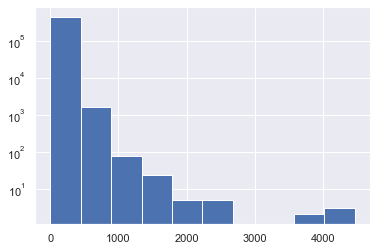

In [25]:
plt.hist(df1_by_users.Rating, log= True)
plt.show() # Entre 0 y 500 usuarios son los que más calificaciones dieron

* Alrededor de 500 usuarios, son los que más calificaciones han dado.

3. ¿Cómo es la distribución de las calificaciones?¿Pueden concluir algo de ese gráfico?

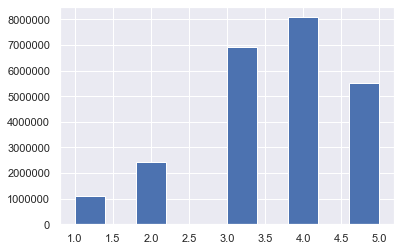

In [26]:
df1['Rating'].hist()
plt.show()

* El mayor número de calificaciones, está alrededor de 4, seguidas de 3, seguidas de 5.

4. ¿Cómo es la distribución del número de calificaciones por usuario?

In [27]:
calificaciones_por_usuario = df1.User.value_counts() # Vemos por usuario, el conteo de dichas calificaciones
calificaciones_por_usuario # 1er columnas es el ID del usuario, la segunda, la cantidad de calificaciones que dió

305344     4467
387418     4422
2439493    4195
1664010    4019
2118461    3769
           ... 
791049        1
99015         1
47493         1
119728        1
2355355       1
Name: User, Length: 470758, dtype: int64

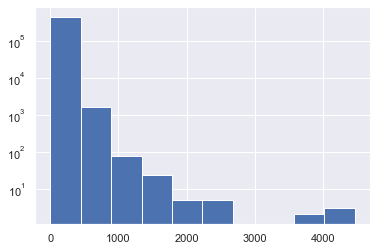

In [28]:
calificaciones_por_usuario.hist(log = True)

* Es el mismo que hicimos arriba, de cantidad de usuarios con más calificaciones.

5. ¿Cuál es la película con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

In [29]:
peliculas_por_vistos = df1.Movie_id.value_counts() # Hacemos un conteo por película, de los valores únicos por película (para c/ Id de película, cuántos hay)
peliculas_por_vistos.index = df_title.loc[peliculas_por_vistos.index].Name # Obtenemos con índice que lo relacionamos con el título, para poder llenar el nombre
peliculas_por_vistos # La película más calificada es Piratas del Caribe

Name
Pirates of the Caribbean: The Curse of the Black Pearl    193941
What Women Want                                           162597
Bruce Almighty                                            160454
The Italian Job                                           156183
American Beauty                                           154832
                                                           ...  
Ghost Hunters: Season 1                                       44
Haven                                                         43
Expo: Magic of the White City                                 42
Hazaaron Khwaishein Aisi                                      39
Bram Stoker's: To Die For                                     36
Name: Movie_id, Length: 4499, dtype: int64

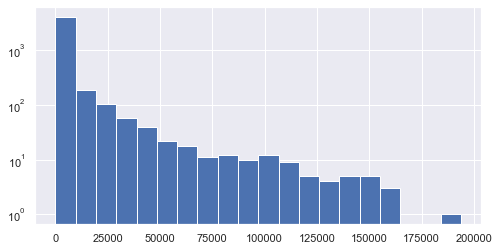

In [30]:
plt.figure(figsize = (8,4))
peliculas_por_vistos.hist(log = True, bins = 20)
plt.show()

* Son pocas las películas que tienen altas calificaciones.
* Hay bastantes películas que tienen pocas calificaciones.